In [1]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from scipy import signal
import os
import sys

## Load measurement data

In [2]:
def readBonsai(path):
    bonsai = pd.read_csv(path)
    bonsai = bonsai[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']]
    return bonsai
    
def readEXLS3(path):
    exl = pd.read_fwf(path)
    exl.columns = exl.iloc[2]
    exl = exl[['a_x [g]:', 'a_y [g]:', 'a_z [g]:', 'ar_x [rad/s]:', 'ar_y [rad/s]:', 'ar_z [rad/s]:']]
    exl.rename(index=str, columns={
        'a_x [g]:': 'accX', 'a_y [g]:': 'accY', 'a_z [g]:': 'accZ', 
        'ar_x [rad/s]:': 'gyrX', 'ar_y [rad/s]:': 'gyrY', 'ar_z [rad/s]:': 'gyrZ'
    }, inplace=True)
    exl = exl.iloc[3:]
    exl.reset_index(drop=True, inplace=True)
    exl = exl.apply(pd.to_numeric)
    exl = exl.multiply(9.80665)
    return exl

def tagColumnNames(df, tag):
    newColumnNames = {columnName: columnName + tag for columnName in df.columns}
    return df.rename(index=int, columns=newColumnNames)


fileNameLocationMap = {
    'I-L9H': 'hip-r',
    'I-74V': 'hip-l',
    'I-WXB': 'knee-r',
    'I-0GN': 'knee-l',
    'Gait - R': 'foot-r',
    'Gait - L': 'foot-l'
}
def mapFileNameToLocation(fileName):
    for name, location in fileNameLocationMap.items():
        if (name in fileName):
            return location
    return 'unknown'

def loadMeasurements(path):
    measurements = {}
    for fileOrDir in os.listdir(path):
        if (fileOrDir.endswith('.txt')):
            measurement = readEXLS3(os.path.join(path, fileOrDir))
        elif (fileOrDir.endswith('.csv')):
            measurement = readBonsai(os.path.join(path, fileOrDir))
        if (measurement is not None):
            measurementLocation = mapFileNameToLocation(fileOrDir)
            measurement = tagColumnNames(measurement, '_' + measurementLocation)
            measurements[measurementLocation] = measurement
    return measurements

# Calibration

In [3]:
zeroMovementWindowSize = 50 # 10ms * zeroMovement

def calibrate(series):
    jumpingWindow = findJumpingWindow(series)
    zeroMovement = series[jumpingWindow[0] - zeroMovementWindowSize : jumpingWindow[0]].mean()
    series -= zeroMovement

## Synchronize the sensor data

In [4]:
numberOfJumps = 3
binSize = 50 # 10ms * binSize = time per bin; bundles neighbor values to avoid multiple amplitudes during same jump

def findJumpingWindow(measurement):
    measurement = measurement.head(int(len(measurement) / 2)) # jumping should be in first half
    absMeasurement = measurement.abs()
    bins = absMeasurement.groupby(pd.cut(absMeasurement.index, np.arange(0, len(measurement), binSize))).max()
    jumpIndicies = list(bins.nlargest(numberOfJumps).sort_index().index)
    lowerBound, upperBound = jumpIndicies[0].left, jumpIndicies[numberOfJumps - 1].right
    return lowerBound - 100, upperBound + 100

In [5]:
def alignSignals(dfX, dfY):
    windowIndiciesDFX = findJumpingWindow(dfX)
    windowIndiciesDFY = findJumpingWindow(dfY)
    windowDFX = dfX[windowIndiciesDFX[0]:windowIndiciesDFX[1]]
    windowDFY = dfY[windowIndiciesDFY[0]:windowIndiciesDFY[1]]
    
    amplitudeOffset = np.argmax(windowDFX.values) - np.argmax(windowDFY.values)    
    windowOffset = windowIndiciesDFX[0] - windowIndiciesDFY[0]
    
    return amplitudeOffset + windowOffset

def alignAccelerationYWithRightFoot(measurements, location, axis):
    offset = alignSignals(
        measurements['foot-r']['accY_foot-r'], 
        measurements[location]['acc' + axis.upper() + '_' + location])
    measurements[location] = measurements[location].shift(offset, axis='index')

# Exercise detection

In [6]:
zeroMovementThreshold = 0.5 # given in meters per second
minSubsequentZeroMovements = 200 

def getNextZeroBlock(series, startPosition):
    start = series[startPosition:][series == 0]
    if (len(start) == 0):
        raise ValueError
    start = start.index[0]
    iValue = start
    zeroCounter = 0
    while (iValue < len(series)):
        if (not series[iValue]):
            zeroCounter += 1
            iValue += 1
        elif (zeroCounter < minSubsequentZeroMovements):
            return getNextZeroBlock(series, iValue + 1)
        else:
            break
    return start, iValue - 1

def findAllNonZeroBlocks(series, startPosition):
    blocks = []
    start = series[startPosition:][series == 1].index[0]
    while (start < len(series)):
        try:
            zeroStart, zeroEnd = getNextZeroBlock(series, start)
            blocks.append((start, zeroStart - 1))
            start = zeroEnd + 1
        except ValueError:
            blocks.append((start, len(series) - 1))
            start = len(series)
    return blocks

def splitDataFrameIntoExercises(df, columnName):
    measurement = df[columnName]
    windowIndicies = findJumpingWindow(measurement)
    filteredByTH = measurement.abs().apply(lambda value: 1 if value > zeroMovementThreshold else 0)
    exerciseIntervals = findAllNonZeroBlocks(filteredByTH, windowIndicies[1])
    return list(map(lambda interval: df[interval[0] : interval[1]], exerciseIntervals))

## Combine loading, calibration, sync and exercise detection

In [237]:
def alignAll(measurements):
    alignAccelerationYWithRightFoot(measurements, 'hip-r', 'y')
    alignAccelerationYWithRightFoot(measurements, 'hip-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'foot-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'knee-l', 'y')
    alignAccelerationYWithRightFoot(measurements, 'knee-r', 'Y')
    
def calibrateAll(measurements):
    for location in measurements.values():
        for column in location.columns:
            calibrate(location[column])

def center(measurements):
    for col in measurements:
        try:
            shift = 0-measurements[col].loc[measurements[col].first_valid_index()]
            measurements[col] = [x+shift if x == x else x for x in measurements[col]]
        except: 
            print("no values for " + col)
        
problem = os.path.join('..', 'data', '24-06-19', 'leonardo 2')
def loadSyncedMeasurements(path):
    measurements = loadMeasurements(path)
    calibrateAll(measurements)
    alignAll(measurements)
    merged = pd.DataFrame()
    for measurement in measurements.values():
        if path == problem:
            measurement = measurement[400:]         # hacky fix for centering issues with leonardo 2 data
        center(measurement)
        merged = merged.join(measurement, how='outer')
    data = [merged] + splitDataFrameIntoExercises(merged, 'accY_foot-r')
    return data

In [238]:
measurements = loadSyncedMeasurements(os.path.join('..', 'data', '24-06-19', 'martin 1'))

no values for gyrY_foot-r


In [239]:
measurements[0]['gyrX_foot-r'].loc[measurements[0]['gyrX_foot-r'].first_valid_index()]

0.0

In [240]:
len(measurements)

13

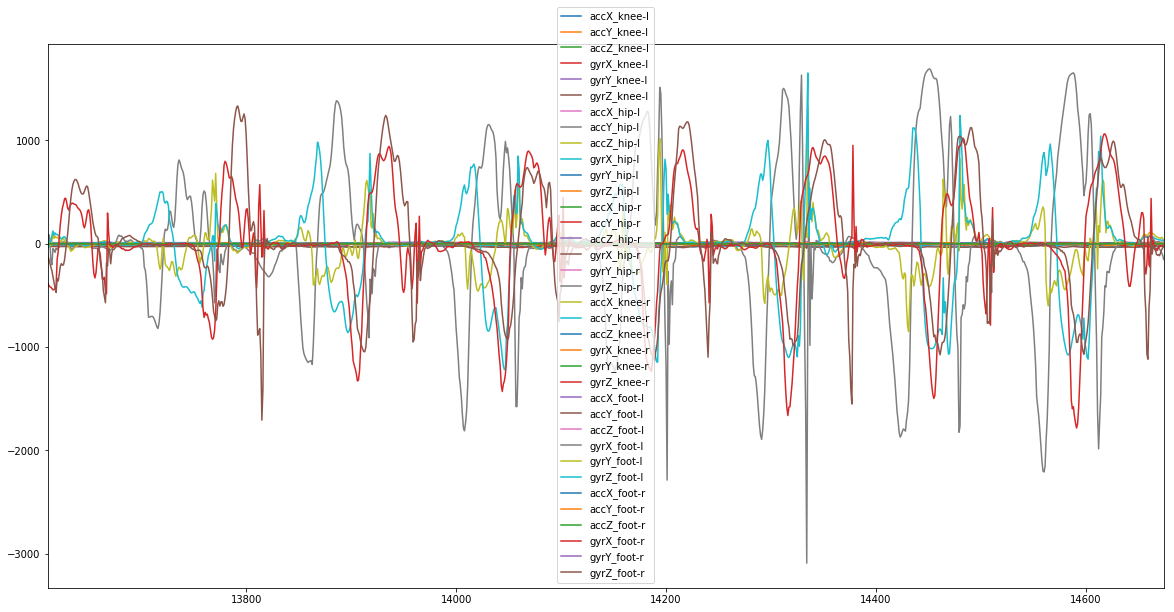

In [256]:
measurements[11].plot(figsize=(20, 10))

for "martin 1"                                   No values for gyrY_foot-r !!
measurements[0] == full
              1 == normal
              2 == Drehung
              3 == hip
              4 == Drehung
              5 == limping
              6 == Drehung
              7 == small steps
              8 == Drehung
              9 == shuffling
              9 == Drehung
              10 == komisches nichts
              11 == unsafe walking
              12 == no data?!

for "martin 2"
measurements[0] == full
              1 == normal + Drehung
              2 == hip
              3 == Drehung
              4 == limping
              5 == Drehung
              6 == small steps
              7 == Drehung
              8 == shuffling
              9 == Drehung
              10 == unsafe walking
              11 == Drehung
              
for "dennis 1"
measurements[0] == full
              1 == normal
              2 == Drehung
              3 == hip
              4 == Drehung
              5 == limping
              6 == Drehung
              7 == small steps
              8 == Drehung
              9 == shuffling
              10 == Drehung
              11 == unsafe walking
              
for "dennis 2"
measurements[0] == full
              1 == normal
              2 == Drehung
              3 == hip
              4 == Drehung
              5 == limping
              6 == Drehung
              7 == small steps
              8 == Drehung
              9 == shuffling + Drehung
              10 == unsafe walking
              
for "leonardo 1"
measurements[0] == full
              1 == full
              
for "leonardo 2"            
measurements[0] == full
              1 == full
              
